In [ ]:
#The Weibull Distribution is a continuous probability distribution used to analyse life data, model failure times and access product reliability.


## The survival function  gives the probability that a component will survive beyond any specified time.

In [1]:
from reliability.Distributions import Weibull_Distribution
import ipywidgets as widgets
from ipywidgets import interact, interactive



style = {'description_width': 'initial'}
btn2 = widgets.BoundedIntText(description='Mission lifetime',style=style,value=6000,min=1000,max=10000000)


@interact(m = btn2)
def sf(m):

    dist = Weibull_Distribution(alpha=210000, beta=1)
    sf = dist.SF(m)
    cdf = dist.CDF(600)
    print('The probability that the component will survive is', round(sf * 100, 2), '%') # we are converting the decimal answer (0.8521...) to a percentage
    #print(cdf)

interactive(children=(BoundedIntText(value=6000, description='Mission lifetime', max=10000000, min=1000, style…

# --------------------------

### Hazard function depicts the likelihood of failure as a function of how long an item has lasted (the instantaneous failure rate at a particular time, t). The hazard plot shows the trend in the failure rate over time

#### The bathtub curve is a model demonstrating the likely failure rates over a certain product lifetime,
####  the bathtub curve shows how many units might fail during any given phase of a three-part timeline. 
##### The first downward portion of the curve is called an “infant mortality” phase and shows how a number of units would quickly fail due to defects or other issues. 
##### The second part of the curve is the “normal lifetime” or “useful lifetime” segment with a low failure rate.
##### The third part is an end-of-life increasing failure rate.

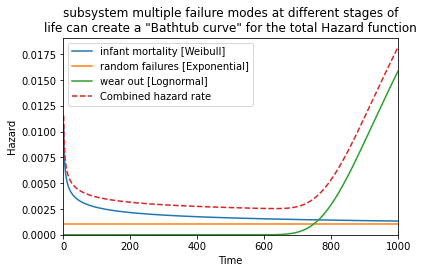

In [2]:
from reliability.Distributions import Weibull_Distribution, Lognormal_Distribution, Exponential_Distribution
import matplotlib.pyplot as plt
import numpy as np
xvals = np.linspace(0,1000,1000)
infant_mortality = Weibull_Distribution(alpha=400,beta=0.7).HF(xvals=xvals,label='infant mortality [Weibull]')
random_failures = Exponential_Distribution(Lambda=0.001).HF(xvals=xvals,label='random failures [Exponential]')
wear_out = Lognormal_Distribution(mu=6.8,sigma=0.1).HF(xvals=xvals,label='wear out [Lognormal]')
combined = infant_mortality+random_failures+wear_out
plt.plot(xvals,combined,linestyle='--',label='Combined hazard rate')
plt.legend()
plt.title('subsystem multiple failure modes at different stages of\nlife can create a "Bathtub curve" for the total Hazard function')
plt.xlim(0,1000)
plt.xlabel('Time')
plt.ylim(bottom=0)
plt.show()

# -----------------

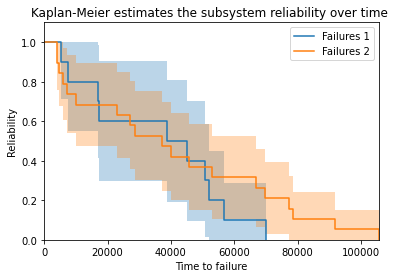

In [8]:
from reliability.Nonparametric import KaplanMeier

f = [5248, 7454, 16890, 17200, 38700, 45000,50700, 52000,56700, 70000]
rc = [3961, 4007, 4734, 6054, 7298, 10190, 23060, 27160, 28690, 37100, 40060, 45670, 53000, 67000, 69630, 77350, 78470, 91680, 105700]
#KaplanMeier(failures=f, right_censored=rc, label='Failures 2',print_results=False)
KaplanMeier(failures=f, label='Failures 1',print_results=False)
KaplanMeier(failures=rc, label='Failures 2',print_results=False)

plt.title('Kaplan-Meier estimates the subsystem reliability over time ')
plt.xlabel('Time to failure')
plt.legend()
plt.show()

# ----------------------------------
## Sample size required for no failures
### Determine the minimum sample size required for a test in which no failures are expected, and the desired outcome is the lower bound on the reliability based on the sample size and desired confidence interval.

In [ ]:

from reliability.Reliability_testing import sample_size_no_failures

b = widgets.Dropdown(description='Reliability',options=[0.95,0.96,0.97,0.98,0.99,0.995])
btn = widgets.Dropdown(description='Confidence ',options=[0.95,0.5,0.6,0.7,0.8,0.9,0.95])
btnn = widgets.BoundedIntText(value=2,min=0,max=15,step=1,description='Testing lifetime',style=style,disabled=False)


@interact(ba=b ,CI = btn,lf = btnn)
def sample_size(ba,CI,lf):
    print('Sample size required to test is: ' )
    return sample_size_no_failures(reliability=ba,CI = CI, print_results = False,lifetimes = lf)

# -----------------------------


## Sequential Sampling Chart 
### Decision boundaries so that a success/failure test may be stopped as soon as there have been enough successes or enough failures to exceed the decision boundary. 

### Decision boundaries to determine should we keep testing or accept/reject the sample

In [ ]:
from reliability.Reliability_testing import sequential_samling_chart


p1 = widgets.Dropdown(description='Acceptable failure rate (Tested sample) ', style = style ,options=[0.01,0.02,0.03,0.04,0.05],value = 0.01)
p2 = widgets.Dropdown(description='Acceptable failure rate (1-Reliability) ',style = style ,options=[0.1,0.2,0.3,0.4,0.05],value = 0.1)
alpha = widgets.Dropdown(description='Producer’s risk (Alpha) ',style = style ,options=[0.01,0.02,0.03,0.04,0.05],value = 0.05)
beta = widgets.Dropdown(description='Consumer’s risk (Beta) ',style = style ,options=[0.1,0.2,0.3,0.4,0.05],value = 0.1)
test = widgets.FileUpload(
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True# True to accept multiple files upload else False
,description='Upload Test Results',layout=widgets.Layout(width='40%', height='50px', border='1px dashed blue'))

@interact(p1=p1 ,p2 = p2,alpha = alpha, beta=beta, t =test )
def sample_size(p1,p2,alpha,beta,t):

    test_results = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1]
    sequential_samling_chart(p1=p1,p2=p2,alpha=alpha,beta=beta,test_results=test_results,print_results= False)

In [1]:
## Reliability test duration
### calculate the required testing duration to achieve the specified risk rate acceptable

# ------------------------------



## Reliability test planner
### calculate the required testing duration 

In [ ]:
from reliability.Reliability_testing import reliability_test_planner, reliability_test_duration
import ipywidgets as widgets
from ipywidgets import interact, interactive
import matplotlib.pyplot as plt


style = {'description_width': 'initial'}
btn = widgets.Dropdown(description='Confidence ',options=[0.5,0.6,0.7,0.8,0.9,0.95])
prod = widgets.Dropdown(description='Producer Risk accepted',options=[0.1,0.2,0.3,0.4,0.5],style=style)
cons = widgets.Dropdown(description='Consumer Risk accepted',options=[0.1,0.2,0.3,0.4,0.5],style=style)
#btn= widgets.Dropdown(description='Number of expected failures',options=df['Description'].unique())
b = widgets.BoundedIntText(value=6,min=0,max=15,step=1,description='Number of expected failures',style=style,disabled=False)
btn2 = widgets.BoundedIntText(description='Test duration',style=style,value=100000,min=1000,max=10000000)

@interact(o = btn,m = btn2,b=b,prod =prod, cons =cons)
def MTBF(o,m,b,cons,prod):
    
    
    
    output = reliability_test_planner(number_of_failures=b, test_duration=m, CI=o, print_results=False)
    print('Expected mean time between failure: ' ,output.MTBF)
    
    
    reliability_test_duration(MTBF_required=output.MTBF, MTBF_design=output.MTBF*1.1, consumer_risk=cons, producer_risk=prod,print_results=False)




